# CycleGAN Walk Through
> A walkthrough of key components to a pytorch CycleGAN implementation.

- toc: true
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]
- hide: true

In this post I will build on my previous posts on GANs and talk about CycleGAN.

In StyleGAN, we took noise generated an image realistic enough to fool the discriminator.  In CycleGAN we take an image and modify it to a different class to make that modified image realistic enough to fool the discriminator into believing it's that class.

I am going to walk through a great [Pytorch CycleGAN implementation](https://github.com/aitorzip/PyTorch-CycleGAN) and explain not just what the pieces are doing in plain english so anyone can understand the important bits without diving through lots of code or reading an academic paper.

Before we jump in - here's the two most important pieces to CycleGAN that we'll be diving into.

1. There are 2 generators and 2 discriminators being trained.  4 total models!
1. The loss function adds a special component which adds the full cycle to the loss function (ie Horse -> generator -> Zebra -> generator -> Horse -> How close is this generated horse to starting horse)

These will be explained in detail as we go so don't worry if that doesn't completely make sense just yet.  It will :)

So let's get started!

In [1]:
from fastai.vision.all import *
from fastcore.basics import *

import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset
import datetime

# Transforms

This implementation of CycleGAN is using basic transforms that are not unique to CycleGAN, so I won't be diving into detail on those in this post.  Please post a comment if you have questions or want a post that talks in more detail on transforms.

In [5]:
transforms_train = [ transforms.Resize(int(256*1.12), Image.BICUBIC), 
                transforms.RandomCrop(256), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
transforms_test = [ transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]

# Dataset

The dataset isn't anything special other than a batch being images from both classes (A and B).  This is a standard pytorch dataloader so I won't cover what's going on in this post, but there is a [great tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) if you would like to understand this more.

There are 2 key things to notice here:
+ A batch is a dictionary of images from class A and images from class B.
+ This example would be style transfer between summer and winter pictures (at Yosemite)

>Note: I have added a show_batch method to the dataloader.  This is an idea I took from fastai and it I highly reccomend making sure you have a very easy way to visualize anything you are working with.  It will save you lots of time if you get that set up.

In [12]:
#collapse-hide
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}A') + '/*.*'))[:50]
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}B') + '/*.*'))[:50]
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned: item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:              item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self): return max(len(self.files_A), len(self.files_B))
    
    def show_batch(self,sets=2, cols=3):
        idxs = random.sample(range(self.__len__()), cols*2*sets)        
        fig, ax = plt.subplots(2*sets, cols,figsize=(4*cols,4*2*sets))
        
        for r in range(sets):
            for col in range(0,cols):
                row=r*2
                num = (row * cols + col)
                x = self[idxs[num]]['A'].permute(1,2,0)
                ax[row,col].imshow(0.5 * (x+1.)); ax[row,col].axis('off')

                row=row+1
                num = (row * cols + col)
                x = self[idxs[num]]['B'].permute(1,2,0)
                ax[row,col].imshow(0.5*(x+1.)); ax[row,col].axis('off')

Rows 1 and 3 are summer pictures (class A) where rows 2 and 4 are winter pictures (class B)

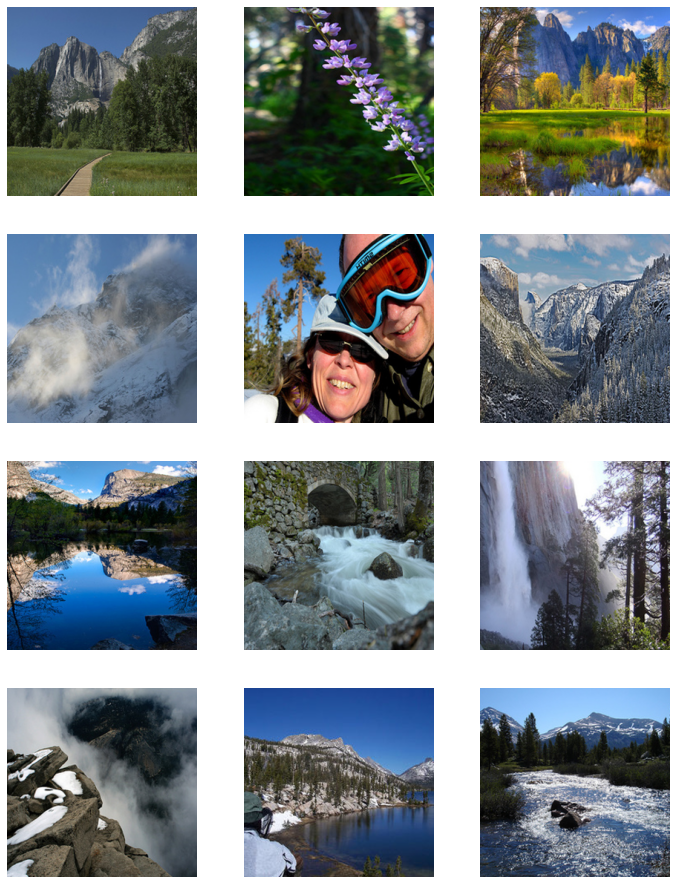

In [14]:
train_dataloader = DataLoader(ImageDataset('datasets/summer2winter_yosemite', transforms_=transforms_train, unaligned=True),batch_size=1, shuffle=True, num_workers=8)
train_dataloader.dataset.show_batch()

# Models

Next, let's talk about the architecture.  You will see that there's nothing super special in the architecture.  The key things are:

+ The discriminator outputs a prediction of whether the image is a real image of that class or a fake image of that class
+ The generator is taking a real image and converting it to the other class.  For example a picture of a lake in the Summer goes in and a picture of that same lake in the winter should come out (maybe adding snow for example).

## Discriminator

As mentioned above, the discriminator is nothing special but let's dive in a bit to prove that.  Here's the components:

+ **Conv2d:**  When working with images convolutions are very common
+ **LeakyReLU:**  While ReLU is more common, Leaky ReLU is used.  We don't want the model to get stuck in a 'no-training' zone that exists with ReLU.  GANs are harder to train well because of the additional complexity of the adversarial model so LeakyReLU works better on GANs generall.
+ **InstanceNorm2d:** BatchNorm is more common, but this is just a small tweak from that.  If you think about the different meanings of the word "Instance" vs "Batch" you make be able to guess what the difference is.  In short BatchNorm is normalizing across the entire batch (computing 1 mean/std).  InstanceNorm is normalizing over the individual image (instance), so you have a mean and std for each image.

>Note: If you think through the impact of batch vs Instance normalization you may realize that with BatchNorm the training for a particular image is effected by which images happen to be in the same batch.  This is becuase the mean and standard deviation are calculated across the entire batch, rather than for that image alone.

In [15]:
#collapse-hide
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

## Generator

The Generator is what generates the image.  It's got a lot of the same components as other Neural Networks.  Let's talk about the components.

We will go through this in 3 sections. 

First let's look at the residual block.  We have Convolutions and ReLUs which is very common to image models.  We see we also have InstanceNorm like we saw in the Discriminator (discussed above).  The new thing is this ReflextionPad2d.  

### Initial Layer

So this is the code from the implementiation for the first bit of the generator (I cut off the rest to be shown later).  Let's understand this first.

We see all the same components we say avove.  `Conv2d` is doing convolutions (big 7x7 ones), we also have InstanceNorm like we saw in the Discriminator (discussed above), and a common activation function `ReLU`.  

The new thing is this ReflectionPad2d.

In [ ]:
#collapse-hide
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

So what is ReflectionPad2d?  First, let's look at what a convolution does.  The blue in the gif below is the image, the white squares are padding.  Normally they're padded with nothing like in the illustration.  What ReflectionPad does is pads that with a reflection of the image instead.  In other words, we are using the pixels values of pixels on the edge to pad instead of just a pure white or pure black pixel.

>Note: Fore more on convolutions [go here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).  The gif below comes from that guide by [Sumit Saha](https://medium.com/@_sumitsaha_) and the guide contains a lot of other create information.

![](https://miro.medium.com/max/395/1*1VJDP6qDY9-ExTuQVEOlVg.gif)

### Downsampling

We then go through several downsampling layers.  A 3x3 convolution with stride 2 will result in a smaller feature map, which is exactly what we are doing to cause the downsampling.  It's all the usual suspects through: `convolutions`, `InstanceNorms`, and `ReLUs`.

In [ ]:
        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

### Residual Blocks

Next we go through some residual blocks.  

In [ ]:
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

When we look at residual blocks again, it's all the same components in slightly different configurations as above.  We have `ReflectionPad`, `Convolutions`, `InstanceNorm`, and `ReLUs`.

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

### Upsampling

Next is upsampling.  There is a new component here which `ConvTranspose`.  Let's take a look at what that is exactly.

In [ ]:
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

So what is this?  Well essentially it's a normal convolution that upsamples by creating padding between cells.  Here's a visual that shows what that looks like.

>Note: Credit for Visualization: Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning

![](https://i.stack.imgur.com/f2RiP.gif)

###  Output Layer

Finally we have out output layer with a `Tanh` activation function.

In [ ]:
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

# Loss Functions

The model using the Adam Optimizer with a scheduler.  I am going to skip over that and look at the most interesting and important part of CycleGAN.  The loss functions!

If you recall, we have both generators and Discriminators.  So we need a loss function for each.  Let's look at each.

## Discriminator Loss

The discriminator loss is a standard adversarial loss.  Let's think through what we would need:

+ Real images of a class (ie Summer Yosimite pictures)
+ Fake images of a class (ie generated Summer Yosimite pictures)
+ Discriminator predictions for whether each image is real or fake

So let's say we generated the images with our generator and then we took the real images from our batch, the fake generated images, and ran that through our disciminator.

Once we have that we use Mean Squared Error as the loss function.  Let's see how this works.  You may notice everything is duplicated in the code.  That's because We have 2 Discriminators:  
+ Is Class A image real or fake?
+ Is Class B image real or fake?

In [ ]:
        # Real loss
        pred_real = netD_A(real_A) # Predict whether real image is real or fake
        loss_D_real = criterion_GAN(pred_real, target_real) # Discriminator wants to accurately determine they are real

        # Fake loss
        pred_fake = netD_A(fake_A.detach()) # Predict whether fake image is real or fake
        loss_D_fake = criterion_GAN(pred_fake, target_fake) # Discriminator wants to accurately determine they are fake

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward() # backward pass
        
        # Real loss
        pred_real = netD_B(real_B) # Predict whether real image is real or fake
        loss_D_real = criterion_GAN(pred_real, target_real) # Discriminator wants to accurately determine they are real

        # Fake loss
        pred_fake = netD_B(fake_B.detach()) # Predict whether fake image is real or fake
        loss_D_fake = criterion_GAN(pred_fake, target_fake) # Discriminator wants to accurately determine they are fake

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward() # backward pass

## Generator Loss - The Key

The generator loss is the key to CycleGAN and it has three main parts to it.

1. Adverserial Loss:  This is standard MSE Loss.  This is the most straightforward loss.  We take the predictions by the Discriminator and the truth of whether the image was generated or real.  The generator is optimizing to fool the Discriminator.
1. Identity Loss: This is L1Loss (pixel by pixel comparison to minimize the difference in pixel values).  If my generator is trained to take a Summer picture and turn it into a Winter picture and I give it winter picture is should do nothing (identity function).  The generator should look at the Winter Picture and determin that nothing needs to be done to make it a Winter picture as that's what it already is.  Identity loss is just trying this out and then comparing the input image with the output image.
1. Cycle Loss:  This is where cycleGAN gets it's name.  L1 loss is just trying to minimize the difference in pixel values.  But how does it have images to compare when it's an unpaired dataset?
    + Start with class A and run your Generator to create class B out of the Class A image
    + Take that class B image that was just generated, and run it through the other generator to create a class A image
    + If all you are doing is transferring styles you should get the exact same image back after the full cycle.  Those are the 2 images being compared.
    
These three components get added up for the loss function.  You can add weights to different portions to prioritize different aspects of the loss function.

So how does this look all together?  You may notice everything is duplicated in the code.  That's because We have 2 generators:  
+ Class A -> Class B or Summer -> Winter
+ Class B -> Class A or Winter -> Summer

In [ ]:
        # Identity loss
        same_B = netG_A2B(real_B) # Generator that's trained to make class B given class B
        loss_identity_B = criterion_identity(same_B, real_B)*5.0 # Calculate difference in pixels

        same_A = netG_B2A(real_A) # Generator that's trained to make class A given class A
        loss_identity_A = criterion_identity(same_A, real_A)*5.0 # Calculate difference in pixels

        # GAN loss
        fake_B = netG_A2B(real_A) # Generator that's trained to make class B given class A 
        pred_fake = netD_B(fake_B) # Discriminator predict is is real or fake
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real) # Generator wants discriminator to think they are real

        fake_A = netG_B2A(real_B) # Generator that's trained to make class A given class B
        pred_fake = netD_A(fake_A) # Discriminator predict is is real or fake
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real) # Generator wants discriminator to think they are real

        # Cycle loss
        recovered_A = netG_B2A(fake_B) # Generator that's trained to make class A given the fake generated class B from above
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0 # Pixel by pixel comparison of original image and recovered image

        recovered_B = netG_A2B(fake_A) # Generator that's trained to make class B given the fake generated class A from above
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0 # Pixel by pixel comparison of original image and recovered image

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB # Add all these losses up
        loss_G.backward() # backward pass

In [ ]:
        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

# Conclusion

That's really the guts of it. You throw that with an optimizer and scheduler in a training loop and you are pretty close to done!  Check out the repository linked at the start of the repository for the full implementaiton with all the details.